In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# !pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=fbbb6c7516c2c013add46c624e5fa0213154e466272a98999e64cd053d3a23c6
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\29\65\6e\db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [36]:
import os
import random

import pandas as pd
import numpy as np

from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchviz import make_dot

In [4]:
class ImageTextDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = self.text_df.iloc[idx, 1:].values[0]

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image


def process_data(attribute_csv_path):
    # Read from csv files
    attributes_df = pd.read_csv(attribute_csv_path)

    # Drop columns
    drop_cols = {"Bags_Under_Eyes", "Bangs", "Blurry", "No_Beard"}
    attributes_df = attributes_df.drop(columns=drop_cols)
    only_attributes = attributes_df.drop(columns="image_id")
    classes = set(only_attributes)
    print("Classes present: ", classes)
    print("Number of classes: ", len(classes))

    return only_attributes, classes


def generate_weights(arr, num_classes):

    # To get the count of each label
    counts = np.zeros(num_classes)
    for row in tqdm(arr):
        idxs = np.where(row == 1)
        counts[idxs] += 1

    # Calculating weight per class
    N = float(sum(counts))
    weight_per_class = np.zeros(num_classes)
    for i in range(num_classes):
        weight_per_class[i] = N / counts[i]

    # Calculating final weights
    weights = [0.0] * len(arr)
    for i, row in tqdm(enumerate(arr)):
        idxs = np.where(row == 1)
        weights[i] = sum(weight_per_class[idxs])
    return weights


def get_weighted_dataloader(
    attribute_csv_path,
    custom_dataset=None,
    image_location=None,
    text_desc_location=None,
    transform=None,
    subset_size=10000,
    batch_size=64,
):

    # Get random indices
    random_indices = torch.randperm(subset_size)
    print("Length of random indices:", len(random_indices))

    only_attributes, classes = process_data(attribute_csv_path)

    only_attributes = only_attributes.iloc[random_indices]
    print("Length of subset dataset:", len(only_attributes))

    # Generate weights
    weights = generate_weights(only_attributes.values, len(classes))

    # Sample based on weights
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    # Create dataset
    if custom_dataset is not None:
        print("Using Custom Dataset Loader...")
        dataset = custom_dataset
    else:
        if image_location is None:
            raise NotImplementedError("Image directory not specified")
        if text_desc_location is None:
            raise NotImplementedError("Text path not specified")
        print("Using ImageTextDataset loader...")
        dataset = ImageTextDataset(
            image_location, text_desc_location, transform=transform
        )

    # Create subset of dataset
    subset_dataset = torch.utils.data.Subset(dataset, random_indices)

    # Create weighted loader
    weighted_dataloader = torch.utils.data.DataLoader(
        subset_dataset,
        batch_size=batch_size,
        shuffle=False,
        sampler=sampler,
        pin_memory=True,
    )

    return weighted_dataloader, iter(weighted_dataloader)

In [4]:
#768 * 768

In [5]:
from sentence_transformers import SentenceTransformer


class SentenceEncoder:
    def __init__(self, device):
        self.bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)
        self.device = device

    def convert_text_to_embeddings(self, batch_text):
        stack = []
        for sent in batch_text:
            l = sent.split(". ")
            sentence_embeddings = self.bert_model.encode(l)
            sentence_emb = torch.FloatTensor(sentence_embeddings).to(self.device)
            sent_mean = torch.mean(sentence_emb, dim=0).reshape(1, -1)
            stack.append(sent_mean)
        output = torch.cat(stack, dim=0)
        return output.detach()

In [6]:
from dataclasses import dataclass,asdict

@dataclass
class Config:
  epochs: int = 50
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3
    
  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
cfg = Config()
cfg_dict = asdict(cfg)

In [8]:
print(torch.cuda.is_available())

True


In [9]:
sentence_encoder = SentenceEncoder(cfg.device)

In [10]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [12]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [13]:
dataset = ImageNTextDataset('img_align_celeba/img_align_celeba', 'text_5_descr_celeba.csv', transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [14]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Male', 'Pointy_Nose', 'Gray_Hair', 'Arched_Eyebrows', 'Smiling', 'Big_Lips', 'Young', 'Bushy_Eyebrows', '5_o_Clock_Shadow', 'Wearing_Hat', 'Black_Hair', 'Receding_Hairline', 'Wearing_Necktie', 'Wearing_Necklace', 'Rosy_Cheeks', 'Mustache', 'Heavy_Makeup', 'Eyeglasses', 'Sideburns', 'High_Cheekbones', 'Oval_Face', 'Chubby', 'Straight_Hair', 'Goatee', 'Wavy_Hair', 'Pale_Skin', 'Mouth_Slightly_Open', 'Wearing_Earrings', 'Attractive', 'Blond_Hair', 'Narrow_Eyes', 'Wearing_Lipstick', 'Bald', 'Big_Nose', 'Brown_Hair', 'Double_Chin'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


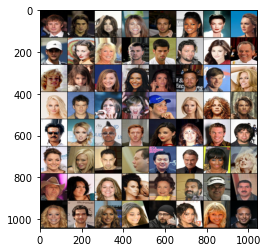

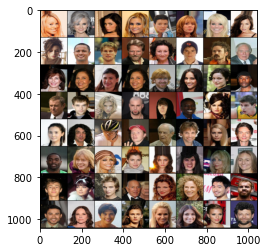

["He grows a 5 o' clock shadow. His hair is brown and wavy. He has a pointy nose. The male is attractive and young. He is wearing a necktie.", "The male has an oval face. He wears a 5 o' clock shadow. He has brown hair. The male seems young.", 'She has wavy hair. She has big lips, narrow eyes and a pointy nose. The woman seems attractive, young, has pale skin and heavy makeup. She is wearing lipstick.', 'The woman has high cheekbones. She has brown and straight hair. She has arched eyebrows, big lips, a slightly open mouth and narrow eyes. The lady is smiling and has heavy makeup. She is wearing lipstick and a necklace.', "He wears a 5 o' clock shadow and has sideburns. His hair is black. He has bushy eyebrows and a pointy nose. The gentleman is attractive and young. He is wearing a necklace.", 'The lady has high cheekbones. Her hair is black, straight and receding. She has big lips, a big nose, a slightly open mouth and a pointy nose. The lady seems young, is smiling and has heavy mak

In [15]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [16]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [17]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [18]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [19]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder 
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)
        
        projected_embed = self.projector(text_embeddings)
        
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)
        
        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [32]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder 
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)
        
        projected_embed = self.projector(text_embeddings)
        
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)
        
        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate



In [39]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()



from torchviz import make_dot

make_dot(discriminator, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

AttributeError: 'Discriminator' object has no attribute 'size'

In [21]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

In [22]:
plt_images, plt_labels, plt_wrong = weighted_dataiter.next()
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

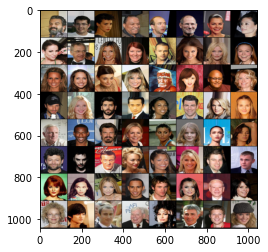

['The gentleman looks chubby, has a double chin and high cheekbones. He grows a goatee and has sideburns. He has wavy hair. He has arched eyebrows, a big nose, bushy eyebrows, a slightly open mouth and narrow eyes. He is smiling.', 'The male has high cheekbones and an oval face. His hair is black. He has a slightly open mouth. The man is smiling and looks young. He is wearing eyeglasses.', 'She has black and wavy hair. She has big lips. The female seems young. She is wearing earrings and lipstick.', 'The male has a chubby face, has a double chin and high cheekbones. He has a mustache. He has a big nose and a slightly open mouth. The gentleman is smiling.', 'The male has an oval face. He is bald. He has a slightly open mouth. The male is young.', "He grows a 5 o' clock shadow, has a goatee and has sideburns. His hair is gray and he is partially bald. He has a big nose and narrow eyes. The man is smiling. He is wearing eyeglasses.", 'The lady has pretty high cheekbones. Her hair is black

In [23]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [24]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [27]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [26]:
pbar = tqdm()

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda() #Optional
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda() #Optional

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)    
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

0it [00:00, ?it/s]

Epoch:  1 / 50


KeyboardInterrupt: 

In [39]:
torch.save(generator.state_dict(), 'E:/Study Material/Projects/TTF_GAN_EDI/generator.pth')

In [40]:
torch.save(discriminator.state_dict(), 'E:/Study Material/Projects/TTF_GAN_EDI/discriminator.pth')

In [29]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The man is chubby, has a double chin and pretty high cheekbones. He grows a sideburns. His hair is gray and receding. He has big lips and a big nose. The man looks young.'])

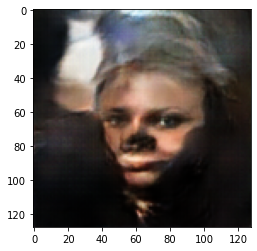

In [30]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [43]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

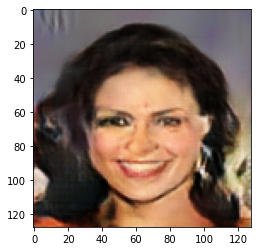

In [44]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [45]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['His hair is wavy. He has big lips, narrow eyes and a pointy nose. The gentleman seems young.'])

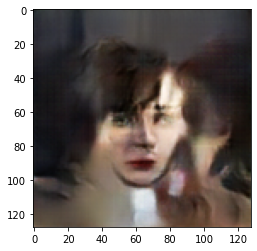

In [46]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [41]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['She has arched eyebrows, big lips, narrow eyes and a pointy nose. The woman looks attractive, young and has heavy makeup. She is wearing lipstick.'])

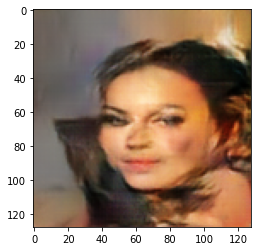

In [42]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [47]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. She has brown hair. She has arched eyebrows and a pointy nose. She is smiling, seems attractive, young, has rosy cheeks and heavy makeup. She is wearing earrings and lipstick.'])

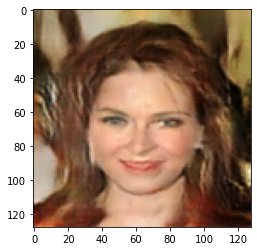

In [48]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [31]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['He wears a 5 o clock shadow. His hair is brown and straight. He has a slightly open mouth and a pointy nose. He looks attractive and young is smiling. He is wearing a necktie.'])

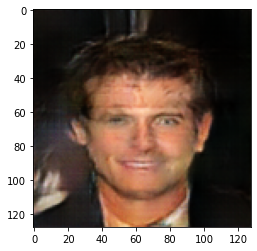

In [32]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [33]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The male has high cheekbones and an oval face. He has big lips and a slightly open mouth. The man seems young.'])

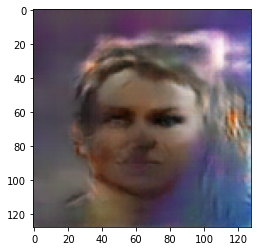

In [34]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [35]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['He has gray hair. He has a big nose and a pointy nose.'])

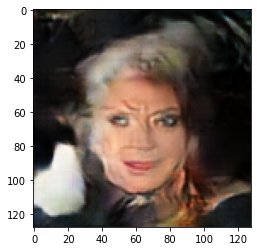

In [36]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [58]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The male has a chubby face. He has sideburns. He has brown and straight hair. He has a big nose. The gentleman is smiling. He is wearing a necktie. ']) 


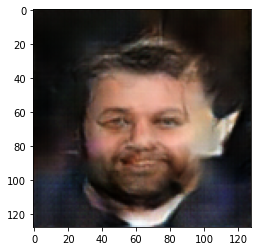

In [59]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))